In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
import numpy as np
import missingno

from IPython.display import display

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
sns.set(color_codes=True)

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from category_encoders import BinaryEncoder

import tensorflow
from tensorflow.keras import optimizers, Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Dense, Layer, InputSpec, Dropout
from tensorflow.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.constraints import UnitNorm, Constraint

In [2]:
df = pd.read_csv("train_data.csv")
timestep = 17 #from 1 to 23 (17 with the current NaN strategy)
fill_X = -0.1
threshold_train = -29.9
X_scaler = StandardScaler()

In [3]:
#Dropping first the empty column and then rows with NaNs
df = df.drop("c_rcs_estimate", axis=1)
df = df.dropna(how='any')

#Filtering events with len=1 or min_tca > 2 or max_tca < 2
def conditions(event):
    x = event["time_to_tca"].values
    return ((x.min()<2.0) & (x.max()>2.0) & (x.shape[0]>1))
df = df.groupby('event_id').filter(conditions)

#OHE for c_object_type (5 categories) -> 5 new features
df = pd.get_dummies(df)

#Binary encoder for mission_id (19 categories) -> 5 new features
encoder = BinaryEncoder(cols=['mission_id'], drop_invariant=True)
df = encoder.fit_transform(df)

#Fitting the scaler X
X_scaler = X_scaler.fit(df)

#Getting train and test dataframe
df["last_value"] = df.groupby(["event_id"])["risk"].transform(lambda x: x.iloc[-1])
df_train = df.loc[df["last_value"]<threshold_train]
df_test = df.loc[df["last_value"]>=threshold_train]

#Dropping feature for slice
df_train = df_train.drop(labels=['last_value'], axis=1)
df_test = df_test.drop(labels=['last_value'], axis=1)

#Getting X as df (dropping rows with tca < 2) 
df_train = df_train.loc[df_train["time_to_tca"]>2]
df_test = df_test.loc[df_test["time_to_tca"]>2]

#Scaling the dataset
df_train = pd.DataFrame(X_scaler.fit_transform(df_train), columns=df_train.columns)
df_test = pd.DataFrame(X_scaler.fit_transform(df_test), columns=df_test.columns)

def df_to_time_series(df):

    #Adding feature 'event_length' for counting how many instances each event has
    df["event_length"] = df.groupby('event_id')['event_id'].transform('value_counts')
    
    #Transforming X into a 3D-array
    events = df["event_id"].nunique() #rows
    features = len(df.columns) #columns
    X = np.zeros((events,timestep,features))
    X.fill(fill_X)
    i = 0
    
    def df_to_3darray(event, X, i):
        #Transforming an event to time series (1,timesteps, columns)
        row = event.values.reshape(1,event.shape[0],event.shape[1])
        #Condition is needed to slice arrays correctly
        #Condition -> is timestep greater than the event's time series length? 
        if(timestep>=row.shape[1]):
            X[i:i+1,-row.shape[1]:,:] = row
        else:
            X[i:i+1,:,:] = row[:,-timestep:,:]
        #index to iterate over X array
        i = i + 1
        #dataframe remains intact, while X array has been filled.
        return event

    df.groupby("event_id").apply(df_to_3darray, X=X, i=i)

    #Dropping event_id to remove noise
    X = X[:,:,1:]
        
    #time_to_tca 0 mission_id 1:5 risk 6
    
    return X

X_train = df_to_time_series(df_train)
X_test = df_to_time_series(df_test)

print(X_train.shape, X_test.shape)

(5890, 17, 3) (1421, 17, 3)


In [4]:
lstm_autoencoder = Sequential()
# Encoder
lstm_autoencoder.add(LSTM(32, activation='selu', stateful=False, 
                          input_shape=(timestep, X_train.shape[2]), return_sequences=True))
lstm_autoencoder.add(Dropout(0.1))
lstm_autoencoder.add(LSTM(16, activation='selu', stateful=False, return_sequences=False))
lstm_autoencoder.add(RepeatVector(timestep))
# Decoder
lstm_autoencoder.add(LSTM(16, activation='selu', stateful=False, return_sequences=True))
lstm_autoencoder.add(Dropout(0.1))
lstm_autoencoder.add(LSTM(32, activation='selu', stateful=False, return_sequences=True))
lstm_autoencoder.add(TimeDistributed(Dense(X_train.shape[2])))

lstm_autoencoder.summary()

# encoder: kernel_constraint=UnitNorm(axis=0)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 17, 32)            4608      
_________________________________________________________________
dropout (Dropout)            (None, 17, 32)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                3136      
_________________________________________________________________
repeat_vector (RepeatVector) (None, 17, 16)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 17, 16)            2112      
_________________________________________________________________
dropout_1 (Dropout)          (None, 17, 16)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 17, 32)            6

In [5]:
epochs = 30
batch = 64
lr = 0.0001

adam = optimizers.Adam(lr)
lstm_autoencoder.compile(loss='mse', optimizer=adam)

#cp = ModelCheckpoint(filepath="lstm_autoencoder_classifier.h5", save_best_only=True,verbose=1)

lstm_autoencoder_history = lstm_autoencoder.fit(X_train, X_train, 
                                                epochs=epochs, 
                                                batch_size=batch, 
                                                shuffle=True, #OJO
                                                validation_split=0.3,
                                                verbose=1).history

Train on 4123 samples, validate on 1767 samples
Epoch 1/30
4123/4123 [==============================] - 8s 2ms/sample - loss: 0.0269 - val_loss: 0.0015
Epoch 2/30
4123/4123 [==============================] - 3s 798us/sample - loss: 0.0208 - val_loss: 0.0012
Epoch 3/30
4123/4123 [==============================] - 3s 786us/sample - loss: 0.0174 - val_loss: 9.4355e-04
Epoch 4/30
4123/4123 [==============================] - 3s 790us/sample - loss: 0.0163 - val_loss: 7.9871e-04
Epoch 5/30
4123/4123 [==============================] - 3s 778us/sample - loss: 0.0150 - val_loss: 6.7431e-04
Epoch 6/30
4123/4123 [==============================] - 3s 761us/sample - loss: 0.0131 - val_loss: 5.9480e-04
Epoch 7/30
4123/4123 [==============================] - 3s 759us/sample - loss: 0.0129 - val_loss: 5.6265e-04
Epoch 8/30
4123/4123 [==============================] - 3s 765us/sample - loss: 0.0093 - val_loss: 4.7072e-04
Epoch 9/30
4123/4123 [==============================] - 3s 760us/sample - loss: 0.

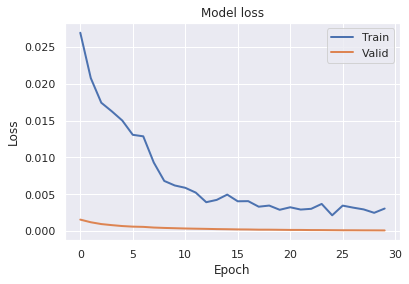

In [6]:
plt.plot(lstm_autoencoder_history['loss'], linewidth=2, label='Train')
plt.plot(lstm_autoencoder_history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

(5890,)


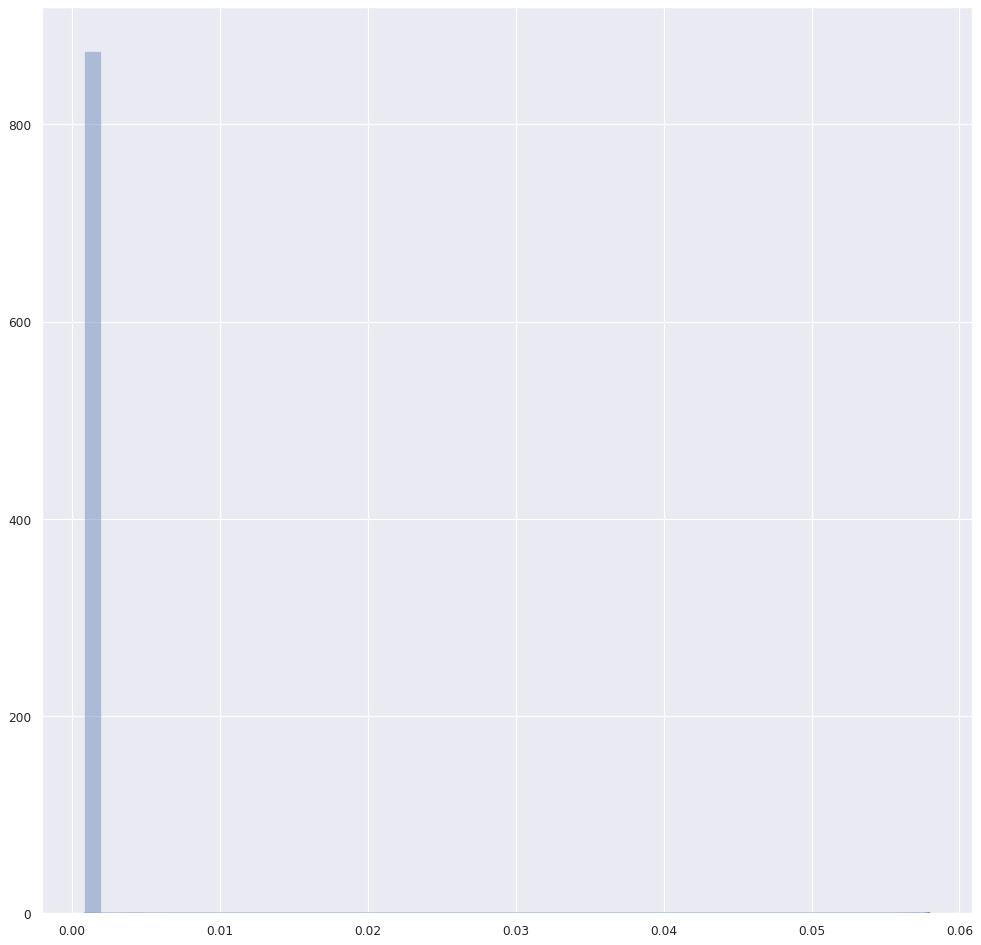

(1421,)


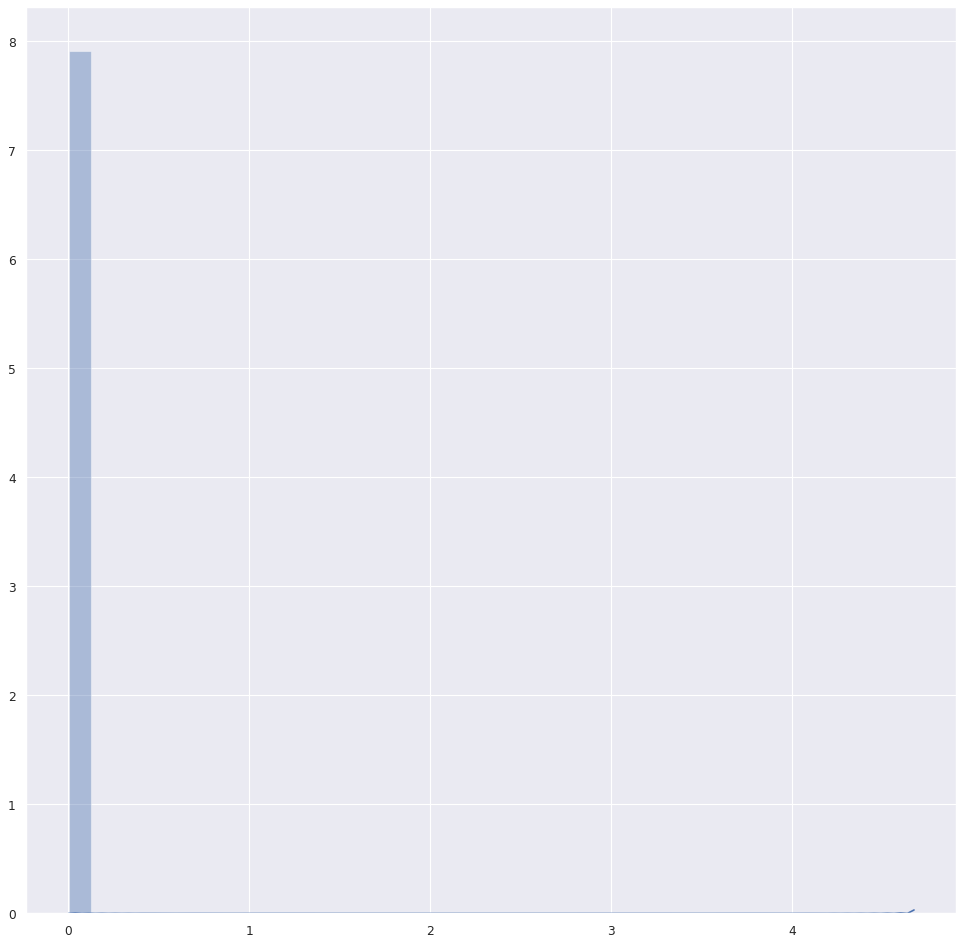

In [12]:
def predict_(X):
    
    X_pred = lstm_autoencoder.predict(X, batch_size=batch)

    X = X.reshape(X.shape[0]*X.shape[1],X.shape[2])
    X_pred = X_pred.reshape(X_pred.shape[0]*X_pred.shape[1],X_pred.shape[2])

    #X = X.astype(np.float64)
    #X_pred = X_pred.astype(np.float64)
    
    #X = X_scaler.inverse_transform(X)
    #X_pred = X_scaler.inverse_transform(X_pred)
    
    X = X[::timestep,6:7]
    X_pred = X_pred[::timestep,6:7]
    
    mse = np.mean(np.power(X-X_pred, 2), axis=1)
    
    print(mse.shape)
    
    plt.figure(figsize=(15, 15), dpi=80)
    sns.distplot(mse)
    #plt.xlim(0, 0.1)
    plt.show()
    
    return mse

mse_train = predict_(X_train)
mse_test = predict_(X_test)

In [13]:
len(mse_test[(mse_test>mse_train.max())])/len(mse_test)


0.0007037297677691766

In [14]:
len(mse_test[(mse_test>mse_train.max())])

1

In [15]:
from scipy import stats
stats.describe(mse_test)

DescribeResult(nobs=1421, minmax=(0.0008365849474402357, 4.673260797358563), mean=0.0041247089533593935, variance=0.015363510218666918, skewness=37.65635011821189, kurtosis=1416.0007042253533)

In [16]:
stats.describe(mse_train)

DescribeResult(nobs=5890, minmax=(0.0008365849474402357, 0.05797625216050747), mean=0.0008462860795412648, variance=5.543194514776471e-07, skewness=76.7267891274497, kurtosis=5885.0001698081205)